# Loan Approval Prediction

This notebook analyses the Loan Approval Prediction data

- https://www.kaggle.com/competitions/playground-series-s4e10/data

### Steps:
- Step 1: Load Data

### Models

xx

### Results

xx

# Step 0: Imports

In [1]:
#--------------------
# General
import pandas as pd
import numpy as np
import copy
pd.set_option('display.max_columns', 10000)
pd.set_option('display.max_rows', 10000)
pd.options.display.float_format = '{:,.2f}'.format
#--------------------

#--------------------
# Seaborn
import seaborn as sns
import matplotlib.pyplot as plt
#--------------------

#--------------------
# Models
# XGBoost
from xgboost import XGBClassifier

# LightGBM
from lightgbm import LGBMClassifier
#--------------------

#--------------------
# SHAP Explainability
import shap
shap.initjs()
#--------------------

#--------------------
# Model Performance
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
#--------------------

#--------------------
# Gini by split
def gini_group(y_true=None, y_score=None, group=None, round=2):
    """
    Calculate Gini for each group
    """
    levels=group.unique()
    values=[]
    for this_level in levels:
        this_y_true=y_true[group==this_level]
        this_y_score=y_score[group==this_level]
        values.append(roc_auc_score(y_true=this_y_true, y_score=this_y_score)*2-1)
    return pd.DataFrame({'group':levels, 'Gini':values}).round(round)
#--------------------

#--------------------
# ROC Curve
def roc_curve_group(y_true=None, y_score=None, group=None, round=2):
    """
    Calculate ROC Curve for each group
    """
    levels=group.unique()
    prep_auc=pd.DataFrame()
    for this_level in levels:
        this_y_true=y_true[group==this_level]
        this_y_score=y_score[group==this_level]
        fpr, tpr, _= roc_curve(y_true=this_y_true, y_score=this_y_score)
        t1=pd.DataFrame({'Model': this_level, 'fpr': fpr, 'tpr': tpr})
        prep_auc=pd.concat([prep_auc, t1], axis=0)
    return prep_auc.round(round)
#--------------------

c:\Users\markt\.virtualenvs\kg-NIDDL6tP\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Step 1: Load Data

In [2]:
# Load Data
df=pd.read_csv("train.csv").drop(columns=['id'])

# Information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58645 entries, 0 to 58644
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  58645 non-null  int64  
 1   person_income               58645 non-null  int64  
 2   person_home_ownership       58645 non-null  object 
 3   person_emp_length           58645 non-null  float64
 4   loan_intent                 58645 non-null  object 
 5   loan_grade                  58645 non-null  object 
 6   loan_amnt                   58645 non-null  int64  
 7   loan_int_rate               58645 non-null  float64
 8   loan_percent_income         58645 non-null  float64
 9   cb_person_default_on_file   58645 non-null  object 
 10  cb_person_cred_hist_length  58645 non-null  int64  
 11  loan_status                 58645 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 5.4+ MB


# Step 2: Plot Data

### Response

### Numerical Features 

### Categorical Featues 

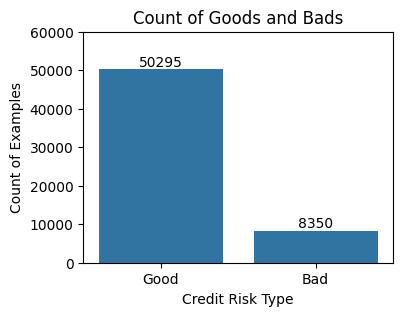

---------------
Population Default Rate
0.14
---------------


In [41]:
# Plot Response

# Summarise for the plot
df_smry=df['loan_status'].value_counts().reset_index()
df_smry['loan_status']=df_smry['loan_status'].map({0:'Good', 1:'Bad'})

# Response plot
plt.figure(figsize=(4,3))
ax=sns.barplot(df_smry, x='loan_status', y='count')
ax.bar_label(ax.containers[0])
ax.set_xlabel('Credit Risk Type')
ax.set_ylabel('Count of Examples')
plt.ylim(0, 60000) 
plt.title('Count of Goods and Bads')
plt.show()

# Population default rate
print('---------------')
print('Population Default Rate')
print(df['loan_status'].mean().round(2))
print('---------------')

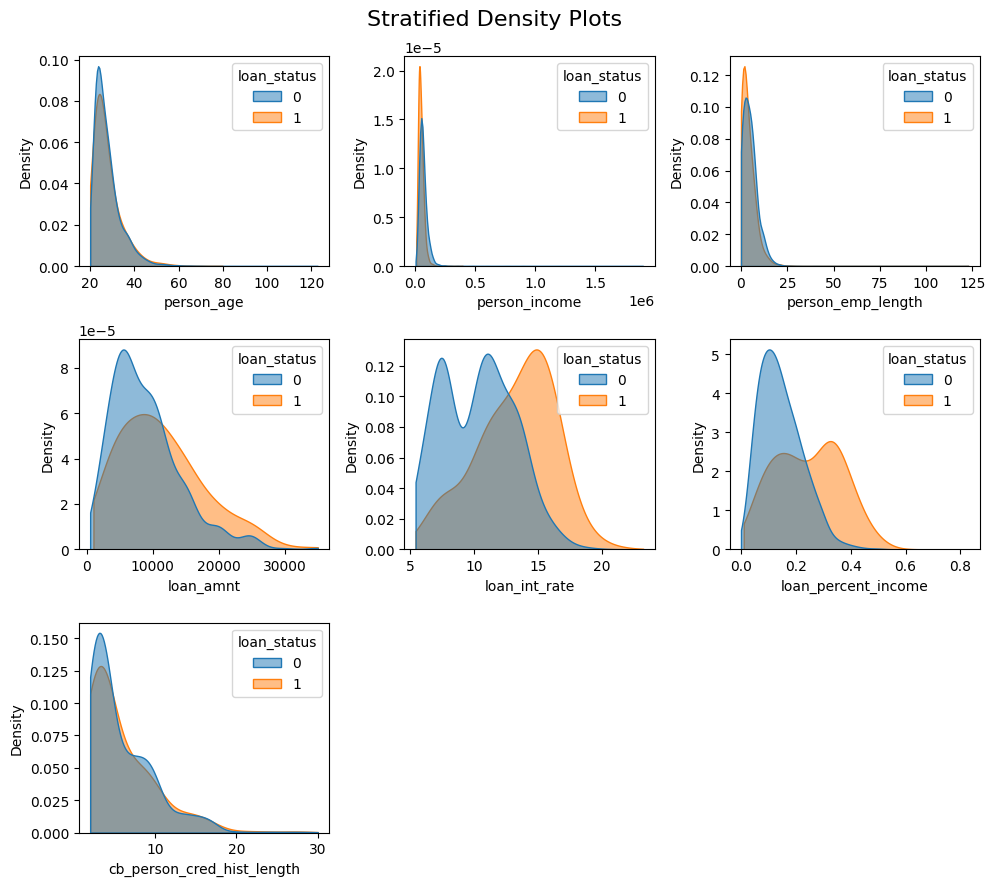

In [ ]:
# Plot Numeric Features

# Numeric Features
numeric_cols = df.select_dtypes(include=[np.number]).columns.drop('loan_status')
num_numeric_cols=len(numeric_cols)

# Set up grid dimensions
cols = 3
rows = (num_numeric_cols + cols - 1) // cols  # Calculate required rows

# Create subplots
fig, axes = plt.subplots(rows, cols, figsize=(10, 3 * rows))
axes = axes.flatten()  # Flatten to make indexing easier

# KDE Plots
for i, this_var in enumerate(numeric_cols):
    sns.kdeplot(data=df, 
                x=this_var, 
                hue='loan_status', 
                fill=True, 
                common_norm=False,
                cut=0,
                alpha=0.5,
                bw_adjust=2.5,
                ax=axes[i])
fig.suptitle('Stratified Density Plots', fontsize=16)

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

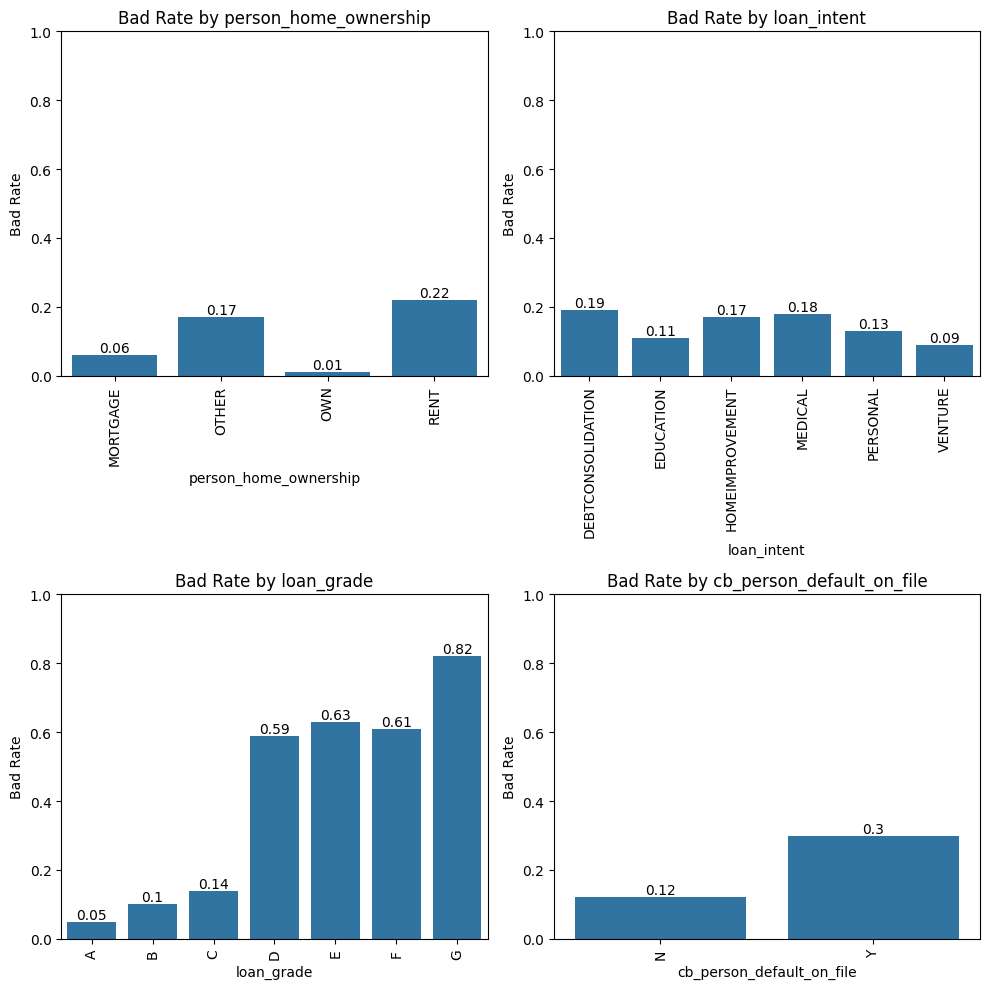

In [ ]:
# Plot Categorical Features

# Identify categorical columns
categorical_cols = df.select_dtypes(exclude=[np.number]).columns
num_categorical_cols = len(categorical_cols)

# Set up grid dimensions
cols = 2
rows = (num_categorical_cols + cols - 1) // cols  # Calculate required rows

# Create subplots
fig, axes = plt.subplots(rows, cols, figsize=(10, 5 * rows))
axes = axes.flatten()  # Flatten to make indexing easier

# Loop over categorical columns
for i, col in enumerate(categorical_cols):
    df_smry = df[['loan_status', col]].groupby(col).mean().reset_index().round(2)

    ax = axes[i]  # Get the current axis
    sns.barplot(data=df_smry, x=col, y='loan_status', ax=ax)
    ax.bar_label(ax.containers[0])
    ax.set_xlabel(col)
    ax.set_ylabel('Bad Rate')
    ax.tick_params(axis='x', rotation=90)
    ax.set_ylim(0, 1)
    ax.set_title(f'Bad Rate by {col}')

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

# Step 2: Information Values

In [47]:
df['loan_status']==1




0        False
1        False
2        False
3        False
4        False
         ...  
58640    False
58641     True
58642     True
58643    False
58644    False
Name: loan_status, Length: 58645, dtype: bool